<a href="https://colab.research.google.com/github/phyop/220505_TensorFlow2/blob/main/220323_%E8%BF%81%E7%A7%BB%E5%AD%A6%E4%B9%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 迁移学习
- 用人家训练好模型的权重参数当做咱们的初始化
- 一般全连接层需要自己训练，可以选择是否训练别人训练好的特征提取层

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
base_dir = '/content/drive/MyDrive/GoogleDrive_yaboaru/Colab Notebooks/220304_唐tensorflow2版本实战/第五章：猫狗识别实战/data/cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

### tensorflow.keras.applications
- 里面有很多现成训练好的模型可以直接利用

In [ ]:
### 导入模型
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
"""
# top指的是全連接FC層，可能像是堆棧的push、pop那種圖示感覺，而不是指paper中的流程圖
>>>include_top = False
# 很多模型架構都是：（conv（relu）+ conv（relu）+ pool）× n次 + FC × 2次 + FC輸出
# 對於上面的結構，一般說的特徵提取，都是指conv + pool
# 參數weights = None，代表權重參數是隨機初始化的；weights = 'imagenet'，代表使用ImageNet的權重當作pre-train；也可以指定自己存放的路徑（必須是h5檔案）
# 要load進預訓好的權重參數，那網路架構必須一樣，不然那些conv、pool等位置不就對不上了嗎
# 執行load進預訓好的權重參數時，會print出一串網址，可以自己copy去迅雷或什麼的方式下載比較方便，不然在colab或jupyter notebook會下載的很慢
# h5文件下載好之後，放到keras指定的資料夾下，然後重新執行剛剛要抓人家當做pre-train的代碼
# 因爲跑code的時候會先去找那個資料夾，看有沒有存在，沒存在才去下載
user -> .keras -> models
"""
pre_trained_model = ResNet101(input_shape = (75, 75, 3), # 输入大小
                                include_top = False, # 不要最后的全连接层
                                weights = 'imagenet')

171458560/171446536 [==============================] - 1s 0us/step


可以选择训练哪些层

In [ ]:
# 全部layer的權重都不做更新
# 因爲include_top = False，所以要自己在後面加上FC層
for layer in pre_trained_model.layers:
    layer.trainable = False

### callback的作用

- 相当于一个监视器，比如訓練集和驗證集的準確率差異，在训练过程中可以设置一些自定义项，提前停止，改变学习率等

callbacks = [

  如果连续两个epoch还没降低就停止：
  
      tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  
  可以动态改变学习率：
  
      tf.keras.callbacks.LearningRateScheduler
      
  保存模型：
  
      tf.keras.callbacks.ModelCheckpoint
      
  自定义方法：
  
      tf.keras.callbacks.Callback
]

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback#example
# 自定義方法可以從API找到，class繼承、def名稱，這種重要的部分都不要改
# 先把callback實現出來，之後在fit的generator當中，再把它傳進去
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
# 這邊不再是用sequential那樣一個個add layer進去
# 全連接的輸入需要是一維數據，所以要把特徵圖做flatten
# pre_trained_model.output應該是個特徵圖，輸入到flatten，然後輸出x
# 全連接layer可以加dropout，避免過擬合
# 基因的力量在于混合的能力而非单个基因的能力，drop out消除减弱了神经元节点间的联合适应性，增强了泛化能力
# 左邊一直都是x，因爲就是一直該層的輸出值，賦予給下一層當輸入值
from tensorflow.keras.optimizers import Adam
x = layers.Flatten()(pre_trained_model.output) 
# 加入全连接层，这个需要重头训练的
x = layers.Dense(1024, activation='relu')(x) # 1024個隱層神經元
x = layers.Dropout(0.2)(x)                  
# 输出层
x = layers.Dense(1, activation='sigmoid')(x) # 1個神經元，因爲只需要知道sigmoid出來後的幾率值，所以輸出1個就好了
# 构建模型序列
model = Model(pre_trained_model.input, x) # Model(輸入，輸出)

model.compile(optimizer = Adam(lr=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [ ]:
# train和validation都要從dir中讀取圖片，所以都需要用到flow_from_dir
# 而train要修正圖片，就需要generator
# validation要rescale圖片，也可以使用generator
# train要利用修正圖片來增加數據量，並且順帶藉由遮蔽等困難辨識，讓模型如果遇到這類圖像也能辨識得出來
# validation只要數據歸一化，比如圖像從0～255改成0～1之間就好了
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (75, 75))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (75, 75))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 训练模型
- 加入Callback()模块

In [ ]:
# 在訓練的時候，可以加入Callback。
# 用法就是，創建一個Callback的實例，然後以list的方式傳給callbacks=
# 因爲有使用generator，所以要把原本的modle.fit，改成model.fit_generator
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/100
100/100 - 493s - loss: 0.9784 - acc: 0.5345 - val_loss: 0.7443 - val_acc: 0.5170 - 493s/epoch - 5s/step
Epoch 2/100
100/100 - 23s - loss: 0.7158 - acc: 0.5225 - val_loss: 0.6779 - val_acc: 0.5900 - 23s/epoch - 234ms/step
Epoch 3/100
100/100 - 22s - loss: 0.6885 - acc: 0.5445 - val_loss: 0.6815 - val_acc: 0.5790 - 22s/epoch - 224ms/step
Epoch 4/100
100/100 - 22s - loss: 0.6895 - acc: 0.5330 - val_loss: 0.6810 - val_acc: 0.5700 - 22s/epoch - 220ms/step
Epoch 5/100
100/100 - 22s - loss: 0.6865 - acc: 0.5320 - val_loss: 0.6851 - val_acc: 0.5230 - 22s/epoch - 220ms/step
Epoch 6/100
100/100 - 22s - loss: 0.6901 - acc: 0.5375 - val_loss: 0.6766 - val_acc: 0.5900 - 22s/epoch - 218ms/step
Epoch 7/100
100/100 - 22s - loss: 0.6866 - acc: 0.5425 - val_loss: 0.6773 - val_acc: 0.5580 - 22s/epoch - 218ms/step
Epoch 8/100
100/100 - 22s - loss: 0.6789 - acc: 0.5600 - val_loss: 0.6666 - val_acc: 0.6130 - 22s/epoch - 224ms/step
Epoch 9/100
100/100 - 23s - loss: 0.6775 - acc: 0.5515 - val_loss

绘图展示

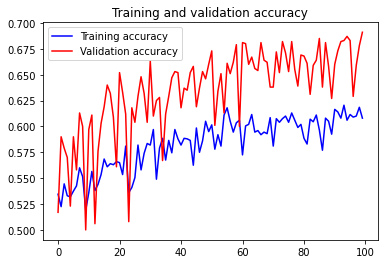

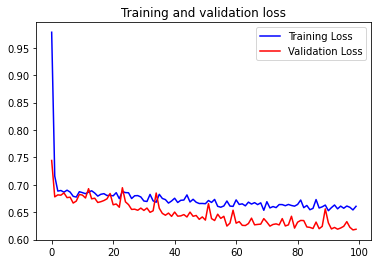

In [ ]:
# 視覺化還是比較容易懂，所以可以畫圖就畫圖吧！
# 而training要畫圖，總少不了history.history
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 反正隨便選一個history.history的元素，看list有多長，就知道跑了幾回epoch
epochs = range(len(acc))

# 基本上就是plt.plot(x值，y值），然後再搜尋怎麼加入label、title、legend
# 做當前沒有任何畫布的時候，會直接把創建的畫布當target，然後畫在上面
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# 但因爲當前已經有一張畫布，所以會把那塊畫布，當作當前畫布使用
# 如果想要指定畫到另一張畫布的話，就需要再創一張新的畫布
# 那就會再把新創的畫布，當作當前畫布使用
plt.figure() 

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

# 全部都設置完之後，就可以顯示出來啦
# 如果plt.show()太早，那跑後面設置顏色什麼的code時，會因爲沒有呼叫要去更新畫面顯示，所以顯示的畫面仍然會是舊的畫面
plt.show()

### 也可以自己选择需要的层，也就是取到哪一层

- last_layer = pre_trained_model.get_layer('层的名字') 